<!-- Minimal helpers (optional, can be reused across cells) -->
<style>
  .rtl {
    direction: rtl;
    text-align: justify;
    line-height: 200%;
    font-family: "Vazir", sans-serif;
  }
  .ltr {
    direction: ltr;
    unicode-bidi: isolate;
  }
  h2.rtl {
    color: #7bd389; /* light green */
  }
</style>

<h2 align="right" class="rtl">

  تعریف مسأله: طبقه‌بندی تومور سینه با <span class="ltr"><strong>SVM (RBF)</strong></span>
</h2>

<p class="rtl">
  در این تمرین، با استفاده از دادهٔ استاندارد <span class="ltr"><strong>Breast Cancer Wisconsin</strong></span> هدف داریم با الگوریتم
  <span class="ltr"><strong>Support Vector Machine</strong></span> (با هستهٔ <span class="ltr"><strong>RBF</strong></span>) پیش‌بینی کنیم که یک تومور
  <strong>بدخیم</strong> (malignant = 0) است یا <strong>خوش‌خیم</strong> (benign = 1). جریان کار شامل:
</p>

<ol dir="rtl" class="rtl" style="padding-right:1.25em">
  <li><strong>بارگذاری داده، تقسیم آموزش/آزمون و استانداردسازی</strong> با <span class="ltr">Pipeline</span> برای جلوگیری از نشتی داده.</li>
  <li><strong>تنظیم ابرپارامترها</strong> با <span class="ltr">GridSearchCV</span> روی <span class="ltr">C</span> و <span class="ltr">gamma</span>.</li>
  <li><strong>ارزیابی</strong> با <span class="ltr">accuracy</span>، <span class="ltr">classification report</span>، و <strong>ماتریس اغتشاش</strong>.</li>
  <li><strong>ROC AUC</strong> و ترسیم منحنی <span class="ltr">ROC</span> برای دیدن رفتار کفایت مدل در آستانه‌های مختلف.</li>
  <li><strong>نمایش دوبعدی</strong> صرفاً جهت <em>تصویری‌سازی آموزشی</em> با <span class="ltr">PCA</span> (مدل اصلی همچنان با ۳۰ ویژگی ارزیابی می‌شود).</li>
</ol>


<!-- Minimal helpers (optional, can be reused across cells) -->
<style>
  .rtl {
    direction: rtl;
    text-align: justify;
    line-height: 200%;
    font-family: "Vazir", sans-serif;
  }
  .ltr {
    direction: ltr;
    unicode-bidi: isolate;
  }
  h2.rtl {
    color: #7bd389; /* light green */
  }
</style>

<h2 align="right" class="rtl">
  گام ۱ — وارد کردن کتابخانه‌ها و تنظیم بذر تصادفی
</h2>

<p class="rtl">
  در این بخش کتابخانه‌های لازم برای داده، مدل، ارزیابی و ترسیم را فراخوانی می‌کنیم.
  همچنین برای <em>تکرارپذیری</em> نتایج، <span class="ltr"><code>RANDOM_STATE</code></span> را ثابت می‌گذاریم.
</p>


In [1]:
# SVM on Breast Cancer Wisconsin dataset (binary)
# ------------------------------------------------
# 1) Data prep: train/test split (stratified) + scaling
# 2) Model selection: RBF SVM with GridSearchCV
# 3) Evaluation: accuracy, confusion matrix, classification report, ROC AUC
# 4) Visualization: PCA to 2D + decision boundary + support vectors (illustrative)

import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.metrics import (
    accuracy_score, confusion_matrix, ConfusionMatrixDisplay,
    classification_report, roc_auc_score, RocCurveDisplay
)
from sklearn.decomposition import PCA



<style>
  .rtl {
    direction: rtl;
    text-align: justify;
    line-height: 200%;
    font-family: "Vazir", sans-serif;
  }
  .ltr {
    direction: ltr;
    unicode-bidi: isolate;
  }
  h2.rtl {
    color: #7bd389; /* light green */
  }
</style>

<h2 align="right" class="rtl">
  گام ۲ — بارگذاری داده و تقسیم آموزش/آزمون (با حفظ نسبت کلاس‌ها)
</h2>

<p class="rtl">
  دادهٔ <span class="ltr"><strong>Breast Cancer</strong></span> شامل ۳۰ ویژگی عددی از تصاویر بافت پستان است. برچسب
  <span class="ltr">y</span> به صورت <span class="ltr">0 = malignant</span> و <span class="ltr">1 = benign</span> است.
  با <span class="ltr"><strong>train_test_split</strong></span> و گزینهٔ <span class="ltr"><code>stratify=y</code></span> نسبت کلاس‌ها را در هر دو بخش حفظ می‌کنیم.
</p>


In [2]:
# 0) Reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# 1) Load & prepare data
data = load_breast_cancer()
X = data.data
y = data.target  # 0 = malignant, 1 = benign

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=RANDOM_STATE, stratify=y
)



<style>
  .rtl {
    direction: rtl;
    text-align: justify;
    line-height: 200%;
    font-family: "Vazir", sans-serif;
  }
  .ltr {
    direction: ltr;
    unicode-bidi: isolate;
  }
  h2.rtl {
    color: #7bd389; /* light green */
  }
</style>

<h2 align="right" class="rtl">
  گام ۳ — پایپ‌لاین استانداردسازی + SVM و تنظیم هایپر پارامتر ها
</h2>

<p class="rtl">
  از آنجا که <span class="ltr"><strong>SVM (RBF)</strong></span> به مقیاس ویژگی‌ها حساس است، ابتدا با
  <span class="ltr"><strong>StandardScaler</strong></span> استانداردسازی می‌کنیم و سپس <span class="ltr"><strong>SVC</strong></span> را اعمال می‌کنیم.
  با <span class="ltr"><strong>GridSearchCV</strong></span> در یک شبکهٔ منطقی، مقادیر مختلف <span class="ltr"><strong>C</strong></span> و
  <span class="ltr"><strong>gamma</strong></span> را تست می‌کنیم. اعتبارسنجی متقاطع <span class="ltr">StratifiedKFold</span> نوسان برآورد را کاهش می‌دهد.
</p>


In [3]:
# 2) Pipeline + Grid Search (RBF SVM)
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('svc', SVC(kernel='rbf', probability=False, random_state=RANDOM_STATE))
])

param_grid = {
    'svc__C':    [0.1, 1, 3, 10, 30, 100],
    'svc__gamma': ['scale', 0.01, 0.03, 0.1, 0.3, 1]
    # Optional: 'svc__class_weight': [None, 'balanced']
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

grid = GridSearchCV(
    pipe, param_grid, cv=cv, scoring='accuracy', n_jobs=-1, refit=True, verbose=0
)
grid.fit(X_train, y_train)

best_model = grid.best_estimator_
print("Best params:", grid.best_params_)
print("Best CV accuracy:", f"{grid.best_score_:.4f}")



Best params: {'svc__C': 3, 'svc__gamma': 0.01}
Best CV accuracy: 0.9742


<style>
  .rtl {
    direction: rtl;
    text-align: justify;
    line-height: 200%;
    font-family: "Vazir", sans-serif;
  }
  .ltr {
    direction: ltr;
    unicode-bidi: isolate;
  }
  h2.rtl {
    color: #7bd389; /* light green */
  }
</style>

<h2 align="right" class="rtl">
  گام ۴ — ارزیابی روی دادهٔ آزمون: دقت، گزارش طبقه‌بندی و ماتریس اغتشاش
</h2>

<p class="rtl">
  با مدل نهایی روی <span class="ltr"><strong>X_test</strong></span> پیش‌بینی می‌کنیم و معیارها را محاسبه/نمایش می‌دهیم.
  <strong>ماتریس اغتشاش</strong> خطاهای نوع مختلف (مثبت/منفی کاذب) را روشن می‌کند.
</p>


<style>
  .rtl {
    direction: rtl;
    text-align: justify;
    line-height: 200%;
    font-family: "Vazir", sans-serif;
  }
  .ltr {
    direction: ltr;
    unicode-bidi: isolate;
  }
  h2.rtl {
    color: #7bd389; /* light green */
  }
</style>

<h2 align="right" class="rtl">
  گام ۵ — منحنی <span class="ltr">ROC</span> و امتیاز <span class="ltr">AUC</span>
</h2>

<p class="rtl">
  برای محاسبهٔ <span class="ltr"><strong>ROC AUC</strong></span> از خروجی پیوستهٔ
  <span class="ltr"><code>decision_function</code></span> استفاده می‌کنیم. هرچه <span class="ltr">AUC</span> به ۱ نزدیک‌تر باشد، جداسازی بهتر است.
</p>


Test accuracy: 0.9790

Classification Report:
              precision    recall  f1-score   support

   malignant       0.96      0.98      0.97        53
      benign       0.99      0.98      0.98        90

    accuracy                           0.98       143
   macro avg       0.98      0.98      0.98       143
weighted avg       0.98      0.98      0.98       143



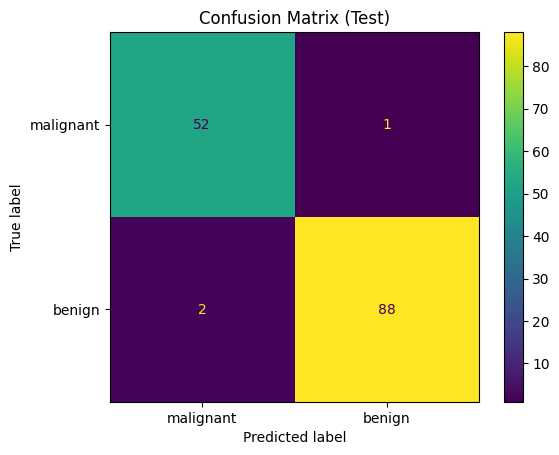

Test ROC AUC: 0.9969


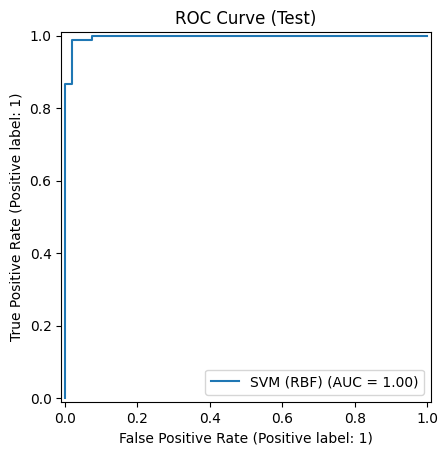

In [4]:
# 3) Evaluation on test set
y_pred = best_model.predict(X_test)
test_acc = accuracy_score(y_test, y_pred)
print("Test accuracy:", f"{test_acc:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=data.target_names))

cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm, display_labels=data.target_names).plot(values_format='d')
plt.title("Confusion Matrix (Test)")
plt.show()

# ROC AUC via decision_function (preferred for SVM)
y_scores = best_model.decision_function(X_test)
roc_auc = roc_auc_score(y_test, y_scores)
print("Test ROC AUC:", f"{roc_auc:.4f}")

RocCurveDisplay.from_predictions(y_test, y_scores, name="SVM (RBF)")
plt.title("ROC Curve (Test)")
plt.show()



<style>
  .rtl {
    direction: rtl;
    text-align: justify;
    line-height: 200%;
    font-family: "Vazir", sans-serif;
  }
  .ltr {
    direction: ltr;
    unicode-bidi: isolate;
  }
  h2.rtl {
    color: #7bd389; /* light green */
  }
</style>

<h2 align="right" class="rtl">
  گام ۶ — تصویری‌سازی آموزشی دوبعدی با <span class="ltr">PCA</span> (اختیاری)
</h2>

<p class="rtl">
  برای <em>نمایش بصری</em> مرز تصمیم در ۲ بعد، دادهٔ ۳۰بعدی را با <span class="ltr"><strong>PCA</strong></span> به ۲ مولفه کاهش می‌دهیم
  و یک <span class="ltr"><strong>SVM</strong></span> دیگر روی فضای ۲بعدی آموزش می‌دهیم. این بخش صرفاً برای <strong>فهم بصری</strong> است
  و جایگزین ارزیابی اصلی روی ۳۰ ویژگی نمی‌شود.
</p>


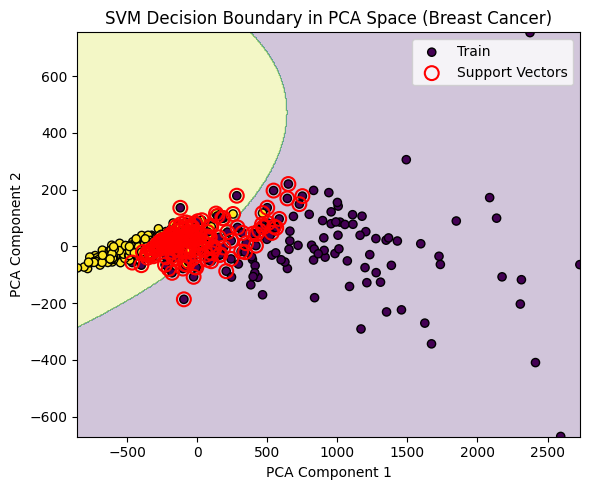

Number of support vectors per class: [79 79]
Total support vectors: 158

Notes:
- Always scale features with SVM (especially RBF).
- C controls margin vs. misclassification penalty; higher C → tighter fit (potential overfitting).
- gamma controls the RBF kernel width; higher gamma → more localized influence (more complex boundaries).
- ROC AUC complements accuracy, especially when class balance or costs differ.


In [5]:
# 4) Visualization in 2D (PCA) — illustrative only
# We reduce to 2 components and train a separate SVM on the 2D space for plotting.
pca = PCA(n_components=2, random_state=RANDOM_STATE)
X_train_2d = pca.fit_transform(X_train)
X_test_2d = pca.transform(X_test)

vis_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('svc', SVC(
        kernel='rbf',
        C=grid.best_params_['svc__C'],
        gamma=grid.best_params_['svc__gamma'],
        probability=False,
        random_state=RANDOM_STATE
    ))
])
vis_pipe.fit(X_train_2d, y_train)
svc_vis = vis_pipe.named_steps['svc']

# Mesh for decision regions
x_min, x_max = X_train_2d[:, 0].min() - 1, X_train_2d[:, 0].max() + 1
y_min, y_max = X_train_2d[:, 1].min() - 1, X_train_2d[:, 1].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 500),
                     np.linspace(y_min, y_max, 500))
Z = vis_pipe.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

plt.figure(figsize=(6, 5))
plt.contourf(xx, yy, Z, alpha=0.25)
plt.scatter(X_train_2d[:, 0], X_train_2d[:, 1], c=y_train, edgecolor='k', s=35, label="Train")
# Plot support vectors (convert from scaled space back to PCA space)
scaler_2d = vis_pipe.named_steps['scaler']
SV_scaled = svc_vis.support_vectors_
SV_2d = scaler_2d.inverse_transform(SV_scaled)
plt.scatter(SV_2d[:, 0], SV_2d[:, 1], s=100, facecolors='none', edgecolors='r', linewidths=1.5, label='Support Vectors')
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("SVM Decision Boundary in PCA Space (Breast Cancer)")
plt.legend(loc="best")
plt.tight_layout()
plt.show()

print("Number of support vectors per class:", svc_vis.n_support_)
print("Total support vectors:", svc_vis.support_.shape[0])

# 5) Quick notes for students
print("\nNotes:")
print("- Always scale features with SVM (especially RBF).")
print("- C controls margin vs. misclassification penalty; higher C → tighter fit (potential overfitting).")
print("- gamma controls the RBF kernel width; higher gamma → more localized influence (more complex boundaries).")
print("- ROC AUC complements accuracy, especially when class balance or costs differ.")


<style>
  .rtl {
    direction: rtl;
    text-align: justify;
    line-height: 200%;
    font-family: "Vazir", sans-serif;
  }
  .ltr {
    direction: ltr;
    unicode-bidi: isolate;
  }
  h2.rtl {
    color: #7bd389; /* light green */
  }
</style>

<h2 align="right" class="rtl">
  جمع‌بندی آموزشی
</h2>

<p class="rtl">
  نکات کلیدی:
</p>
<ol dir="rtl" class="rtl" style="padding-right:1.25em">
  <li><strong>استانداردسازی</strong> برای <span class="ltr">SVM (RBF)</span> ضروری است.</li>
  <li><strong><span class="ltr">C</span></strong> و <strong><span class="ltr">gamma</span></strong> توازن <em>سادگی/پیچیدگی</em> مرز تصمیم را کنترل می‌کنند:
    <span class="ltr">C</span> بزرگ و <span class="ltr">gamma</span> بزرگ معمولاً مرزهای پیچیده‌تر می‌سازند (خطر بیش‌برازش).</li>
  <li><strong>ماتریس اغتشاش</strong> نوع خطاها را آشکار می‌کند (مثبت/منفی کاذب).</li>
  <li><strong>ROC AUC</strong> دید مناسبی از عملکرد مدل مستقل از آستانه می‌دهد.</li>
  <li>نمایش دوبعدی با <span class="ltr">PCA</span> فقط برای <em>درک بصری</em> است؛ ارزیابی نهایی با همهٔ ویژگی‌ها اهمیت دارد.</li>
</ol>
